In [1]:
import numpy as np
import pandas as pd
from gower.gower_dist import *

In [2]:
df = pd.DataFrame({"Sex1": ["M", "M", "F", "F", "F", "M", "M", "F", "F", "F"],
                   "Sex2": ["M", "M", "F", "F", "F", "F", "F", "M", "M", "M"],
                   "Age1": [15] * 10,
                   "Age2": [15, 36, 58, 78, 100, 15, 36, 58, 78, 100]})

In [3]:
distances = np.diag(gower_matrix(df[["Sex1", "Age1"]].to_numpy(), df[["Sex2", "Age2"]].to_numpy(), weight=np.ones(2)))
print(distances)
df.loc[np.argsort(distances)]

  0%|          | 0/10 [00:00<?, ?it/s]

[0.         0.12352941 0.25294118 0.37058824 0.5        0.5
 0.62352941 0.75294118 0.87058824 1.        ]


,Sex1,Sex2,Age1,Age2
0,M,M,15,15
1,M,M,15,36
2,F,F,15,58
3,F,F,15,78
4,F,F,15,100
5,M,F,15,15
6,M,F,15,36
7,F,M,15,58
8,F,M,15,78
9,F,M,15,100


In [4]:
distances = np.diag(gower_matrix(df[["Sex1", "Age1"]].to_numpy(), df[["Sex2", "Age2"]].to_numpy(), R=(25, 75)))
print(distances)
df.loc[np.argsort(distances)]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[0.         0.40064209 0.82036237 0.82036237 0.82036237 0.17963763
 0.58027972 1.         1.         1.        ]


,Sex1,Sex2,Age1,Age2
0,M,M,15,15
5,M,F,15,15
1,M,M,15,36
6,M,F,15,36
2,F,F,15,58
3,F,F,15,78
4,F,F,15,100
7,F,M,15,58
8,F,M,15,78
9,F,M,15,100


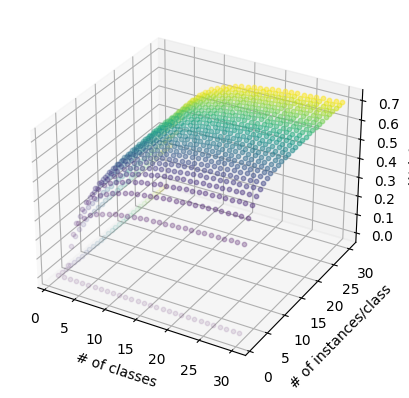

In [28]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = mcolors._colors_full_map

ax = plt.axes(projection="3d")

MAX = 30

for i in range(1, MAX + 1):
    X = []
    for j in range(1, MAX + 1):
        x = get_cat_weight(list(''.join(chr(k) for k in range(i))) * j)
        ax.scatter3D(i, j, x, alpha=0.9*x**2+0.1, c=j, s=10, vmin=1, vmax=MAX)
        X.append(x)
ax.set_xlabel("# of classes")
ax.set_ylabel("# of instances/class")
ax.set_zlabel("Weight")

plt.show()


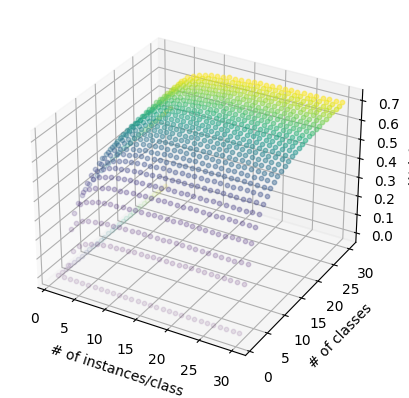

In [30]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = mcolors._colors_full_map

ax = plt.axes(projection="3d")

MAX = 30

for i in range(1, MAX + 1):
    X = []
    for j in range(1, MAX + 1):
        x = get_cat_weight(list(''.join(chr(k) for k in range(i))) * j)
        ax.scatter3D(j, i, x, alpha=0.9*x**2+0.1, c=i, s=10, vmin=1, vmax=MAX)
        X.append(x)
ax.set_ylabel("# of classes")
ax.set_xlabel("# of instances/class")
ax.set_zlabel("Weight")

plt.show()


In [7]:
dd = pd.read_csv("dog_adoption/allDogDescriptions.csv", index_col=0)

# get rid of columns with the most destructive nans

def isolate_nans(column):
    all_other_nans = nans[[c for c in cols if c != column]].sum(axis=1)
    mask = all_other_nans < np.median(all_other_nans)
    mask &= nans[column]
    return mask.sum()

nans = dd.isna()
cols = dd.columns
isolated_nans = {c: isolate_nans(c) for c in cols}
median_count = np.median([v for v in isolated_nans.values() if v > 0])
for column, count in isolated_nans.items():
    if count > median_count:
        print(column)
        dd.drop(column, axis=1, inplace=True)
dd.dropna(inplace=True)  # dd.mode().iloc[0]

# make bools strings

is_bool = dd.dtypes == bool
dd.loc[:, is_bool] = dd[dd.columns[is_bool]].astype(str)

breed_secondary
color_primary
color_secondary
color_tertiary
declawed
env_cats


In [8]:
matrix = gower_matrix(dd.to_numpy(), chunksize=20)

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/13729 [00:00<?, ?it/s]

In [9]:
pd.DataFrame(matrix).describe()

,0,1,2,3,4,5,6,7,8,9,...,13719,13720,13721,13722,13723,13724,13725,13726,13727,13728
count,13729.000000,13729.000000,13729.000000,13729.000000,13729.000000,13729.000000,13729.000000,13729.000000,13729.000000,13729.000000,...,13729.000000,13729.000000,13729.000000,13729.000000,13729.000000,13729.000000,13729.000000,13729.000000,13729.000000,13729.000000
mean,0.828427,0.762654,0.779948,0.798046,0.798345,0.798067,0.798332,0.779935,0.798045,0.764536,...,0.797579,0.798470,0.780515,0.772524,0.758924,0.769847,0.766684,0.806140,0.863627,0.840208
std,0.042874,0.054476,0.048104,0.050596,0.051284,0.050574,0.051293,0.048114,0.050619,0.058093,...,0.051525,0.046386,0.052962,0.048770,0.055651,0.055273,0.052832,0.047460,0.041556,0.041990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.810247,0.729749,0.750067,0.768940,0.769263,0.769072,0.769261,0.750056,0.768986,0.729574,...,0.763916,0.771372,0.744500,0.743129,0.725991,0.742596,0.734306,0.776271,0.841967,0.813496
50%,0.831797,0.765822,0.781943,0.805716,0.801902,0.805715,0.801901,0.781924,0.805715,0.765422,...,0.802879,0.797492,0.778781,0.768174,0.760949,0.769517,0.767088,0.811270,0.869800,0.849243
75%,0.852312,0.797071,0.807346,0.831408,0.833139,0.831407,0.833138,0.807344,0.831407,0.803336,...,0.838348,0.829419,0.816019,0.803853,0.797979,0.804526,0.803100,0.835021,0.890855,0.869639
max,0.957618,0.930467,0.940291,0.939428,0.946004,0.939427,0.946002,0.940290,0.939427,0.918362,...,0.922569,0.928934,0.930286,0.919288,0.916177,0.927178,0.939979,0.941565,0.952377,0.940463


In [10]:
matrix

array([[0.        , 0.44147068, 0.42099365, ..., 0.89437986, 0.9119966 ,
        0.82957874],
       [0.44147068, 0.        , 0.34600772, ..., 0.8159793 , 0.89047105,
        0.85110429],
       [0.42099365, 0.34600772, 0.        , ..., 0.83521809, 0.91094807,
        0.83062725],
       ...,
       [0.89437986, 0.8159793 , 0.83521809, ..., 0.        , 0.78531712,
        0.73250739],
       [0.9119966 , 0.89047105, 0.91094807, ..., 0.78531712, 0.        ,
        0.45039882],
       [0.82957874, 0.85110429, 0.83062725, ..., 0.73250739, 0.45039882,
        0.        ]])

In [11]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(min_samples=2, metric="precomputed")
dd["gower_dbscan"] = dbscan.fit_predict(matrix)

In [12]:
np.unique(dd["gower_dbscan"], return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176

In [13]:
dd["label_count"] = dd.groupby("gower_dbscan").transform("count").iloc[:, 0]
dd.sort_values(["gower_dbscan", "label_count"], ascending=[True, False], inplace=True)
dd

,id,org_id,url,type.x,species,breed_primary,breed_mixed,breed_unknown,age,sex,...,contact_city,contact_state,contact_zip,contact_country,stateQ,accessed,type.y,description,gower_dbscan,label_count
index,,,,,,,,,,,,,,,,,,,,,
457,45087942,NV99,https://www.petfinder.com/dog/peanut-45087942/...,Dog,Dog,Border Collie,True,False,Senior,Male,...,Mesquite,NV,89027,US,89009,2019-09-20,Dog,Peanut is up for adoption! He is a Border Coll...,-1,236
1021,44238778,UT176,https://www.petfinder.com/dog/mikie-44238778/u...,Dog,Dog,Pit Bull Terrier,False,False,Adult,Male,...,La Verkin,UT,84745,US,89024,2019-09-20,Dog,ADOPTABLE!\nWould you look at that sweet face?...,-1,236
1133,45878098,CA941,https://www.petfinder.com/dog/maddie-45878098/...,Dog,Dog,Dachshund,False,False,Young,Female,...,reno,NV,89511,US,89406,2019-09-20,Dog,Name: Maddie #4734\nAge: Aprx 1 year\nColor:...,-1,236
1159,45642530,NV160,https://www.petfinder.com/dog/yeti-courtesy-li...,Dog,Dog,Jindo,False,False,Adult,Male,...,Gardnerville,NV,89460,US,89406,2019-09-20,Dog,"The following dog is not, nor has he ever been...",-1,236
1183,45052838,NV211,https://www.petfinder.com/dog/katie-45052838/n...,Dog,Dog,Corgi,True,False,Senior,Female,...,Washoe Valley,NV,89704,US,89406,2019-09-20,Dog,Looking for a buddy to binge your favorite sho...,-1,236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58042,40943505,OH571,https://www.petfinder.com/dog/diesel-40943505/...,Dog,Dog,Pit Bull Terrier,False,False,Adult,Male,...,Long Bottom,OH,45743,US,WV,2019-09-20,Dog,Diesel was brought to us with the understandin...,257,7
58080,37985914,OH571,https://www.petfinder.com/dog/sunny-37985914/o...,Dog,Dog,Hound,True,False,Young,Female,...,Long Bottom,OH,45743,US,WV,2019-09-20,Dog,Sunny is a very sweet girl who loves children....,257,7
58082,37680518,OH571,https://www.petfinder.com/dog/buddy-37680518/o...,Dog,Dog,Black Labrador Retriever,True,False,Young,Male,...,Long Bottom,OH,45743,US,WV,2019-09-20,Dog,Buddy is very good with children and other dog...,257,7


In [14]:
pokemon = pd.read_csv("pokemon/pokemon_alopez247.csv")
matrix = gower_matrix(pokemon.dropna(axis=1).to_numpy(), chunksize=20)
print(matrix)
pokemon["gower_dbscan"] = DBSCAN(eps=0.15, min_samples=2, metric="precomputed").fit_predict(matrix)
np.unique(pokemon["gower_dbscan"], return_counts=True)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

[[0.         0.07002255 0.14143091 ... 0.51143336 0.51594219 0.47346036]
 [0.07002255 0.         0.10012189 ... 0.48603754 0.4792406  0.43215135]
 [0.14143091 0.10012189 0.         ... 0.4607417  0.46021691 0.39043676]
 ...
 [0.51143336 0.48603754 0.4607417  ... 0.         0.25564207 0.25794528]
 [0.51594219 0.4792406  0.46021691 ... 0.25564207 0.         0.23095105]
 [0.47346036 0.43215135 0.39043676 ... 0.25794528 0.23095105 0.        ]]


(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]),
 array([201, 230,  48,  29,   2,   2,   4,   2,   2,   4,   9,   3,   2,
          6,  12,   2,   2,   3,   2,   5,   2,   2,   2,   2,   4,   2,
          2,   2,   2,   3,   2,   8,   2,   2,   3,   2,   2,   3,   2,
          2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
          2,   2,   2,   2,   6,   2,   2,   2,   2,   3,   2,   4,   4,
          3,   2,   2,   4,   2,   2,   2,   2,   3,   2,   2,   5,   2,
          2,   2,   2,   2]))

In [15]:
pokemon["label_count"] = pokemon.groupby("gower_dbscan").transform("count").iloc[:, 0]
pokemon.sort_values(["gower_dbscan", "label_count"], ascending=[True, False], inplace=True)
pokemon


,Number,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,...,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style,gower_dbscan,label_count
42,43,Oddish,Grass,Poison,320,45,50,55,75,65,...,0.500,Grass,NaN,False,0.51,5.4,255,head_legs,-1,201
49,50,Diglett,Ground,NaN,265,10,55,25,35,45,...,0.500,Field,NaN,False,0.20,0.8,255,head_base,-1,201
50,51,Dugtrio,Ground,NaN,405,35,80,50,50,70,...,0.500,Field,NaN,False,0.71,33.3,50,multiple_bodies,-1,201
65,66,Machop,Fighting,NaN,305,70,80,50,35,35,...,0.750,Human-Like,NaN,False,0.79,19.5,180,bipedal_tailed,-1,201
73,74,Geodude,Rock,Ground,300,40,80,100,30,30,...,0.500,Mineral,NaN,False,0.41,20.0,255,head_arms,-1,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,702,Dedenne,Electric,Fairy,431,67,58,57,81,67,...,0.500,Field,Fairy,False,0.20,2.2,180,bipedal_tailed,78,2
697,698,Amaura,Rock,Ice,362,77,59,50,67,63,...,0.875,Monster,NaN,False,1.30,25.2,45,quadruped,79,2
698,699,Aurorus,Rock,Ice,521,123,77,72,99,92,...,0.875,Monster,NaN,False,2.69,225.0,45,quadruped,79,2
703,704,Goomy,Dragon,NaN,300,45,50,35,55,75,...,0.500,Dragon,NaN,False,0.30,2.8,45,serpentine_body,80,2
